# Wallet Feature Engineering

The purpose of this notebook is to create features from OpenSea `Asset Events` time series
in order to:
- model and predict NFT fear of missing out (FOMO) behavior
- classify types of people participating in NFT exchanges

# Read Data

__Description of the dataset:__ Asset events ("events") were extracted by
 [莊惟翔](https://github.com/Fred-Zhuang)
via https://api.opensea.io/api/v1/assets endpoint.
This dateset contains only __successful__ events having occurred on the NFTs
and been tracked by OpenSea.

1. a list of `token_seller_address` having event timestamp
    between 2022-05-03 and 2022-05-18 was used as the primer to
    extract all events involving these addresses
    (see `os_successful_events.feather`)
2. the final list of events was then used for feature engineering

*The `event_type` indicates the types of events (transfer, successful auction, etc)
and the results are sorted by `event_timestamp`
(see [OpenSea API documentation](https://docs.opensea.io/reference/getting-assets)).

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns

data_dir = os.path.join(os.getcwd(), 'data')
cool_cats_nft = os.path.join(data_dir, 'cool-cats-nft.feather')

start_time = time.time()
wallets = pd.read_feather(cool_cats_nft)
total_time = time.time() - start_time
print("Total seconds to load:", total_time)

Total seconds to load: 7.371005535125732


In [2]:
wallets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398450 entries, 0 to 2398449
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   index                   2398450 non-null  int64         
 1   event_timestamp         2398450 non-null  datetime64[ns]
 2   event_type              2398450 non-null  object        
 3   token_id                2382796 non-null  object        
 4   num_sales               2382796 non-null  float64       
 5   listing_time            2268796 non-null  datetime64[ns]
 6   token_owner_address     2382796 non-null  object        
 7   token_seller_address    2395806 non-null  object        
 8   deal_price              2398450 non-null  float64       
 9   payment_token_symbol    2398411 non-null  object        
 10  payment_token_decimals  2398445 non-null  float64       
 11  payment_token_usdprice  2397937 non-null  float64       
 12  quantity      

In [3]:
wallets.drop(["index", "starting_price", "ending_price",
              "approved_account", "bid_amount",
              "pages"], axis=1, inplace=True)

In [4]:
print("Most recent event:", max(wallets.event_timestamp))

Most recent event: 2022-05-10 23:35:55


In [5]:
print("Earliest event:", min(wallets.event_timestamp))

Earliest event: 2017-07-04 04:33:49


In [6]:
print("Length of this time series dataset:", max(wallets.event_timestamp) - min(wallets.event_timestamp))

Length of this time series dataset: 1771 days 19:02:06


In [7]:
print("Total number of wallet addresses used to retrieve data from OpenSea:", wallets.wallet_address_input.nunique())

Total number of wallet addresses used to retrieve data from OpenSea: 9766


## Top collections in this dataset

In [8]:
wallets.groupby(by="collection_slug", as_index=False).size().sort_values(by="size", ascending=False).head(21)

,collection_slug,size
4714,cool-cats-nft,39846
16789,parallelalpha,18308
18021,pudgypenguins,13679
6476,deadfellaz,12764
18847,robotos-official,11859
3328,boredapeyachtclub,11832
18454,rarible,11239
15021,mutant-ape-yacht-club,10691
22625,thewickedcraniums,10569
5311,cryptoadz-by-gremplin,10207


\* _`size` represents the number of successful sales._

### Comparing top collection with our list of 20 NFT collections

In [9]:
nft20 = pd.read_csv(os.path.join(os.getcwd(), 'NFT_20_list.csv'))
nft20_collection_slug = [os.path.basename(url) for url in nft20.collection_url]
nft20_collection_slug

['boredapeyachtclub',
 'mutant-ape-yacht-club',
 'azuki',
 'clonex',
 'proof-moonbirds',
 'doodles-official',
 'meebits',
 'cool-cats-nft',
 'bored-ape-kennel-club',
 'cryptoadz-by-gremplin',
 'world-of-women-nft',
 'hapeprime',
 'mekaverse',
 'karafuru',
 'invisiblefriends',
 'mfers',
 'phantabear',
 'cyberkongz-vx',
 'coolpetsnft',
 'lazy-lions',
 'kaiju-kingz']

In [10]:
wallets[wallets.collection_slug.isin(nft20_collection_slug)] \
    .groupby(by="collection_slug", as_index=False).size() \
    .sort_values(by="size", ascending=False)

,collection_slug,size
4,cool-cats-nft,39846
2,boredapeyachtclub,11832
17,mutant-ape-yacht-club,10691
6,cryptoadz-by-gremplin,10207
5,coolpetsnft,8916
1,bored-ape-kennel-club,8841
8,doodles-official,8515
20,world-of-women-nft,7684
7,cyberkongz-vx,7680
0,azuki,6670


## Data distribution (WIP)

... this project selects only transaction involving top-20 nft collections 

In [11]:
top20_nft = wallets.groupby(by="collection_slug").size().sort_values(ascending=False).iloc[:20].index
top20_nft

Index(['cool-cats-nft', 'parallelalpha', 'pudgypenguins', 'deadfellaz',
       'robotos-official', 'boredapeyachtclub', 'rarible',
       'mutant-ape-yacht-club', 'thewickedcraniums', 'cryptoadz-by-gremplin',
       'ape-gang-old', 'creatureworld', 'coolpetsnft', 'bored-ape-kennel-club',
       'supducks', 'doodles-official', 'animetas', 'adam-bomb-squad',
       'world-of-women-nft', 'cyberkongz-vx'],
      dtype='object', name='collection_slug')

In [12]:
sum(wallets.collection_slug.isin(top20_nft))

237883

In [13]:
sum(wallets.collection_slug.isin(top20_nft)) / wallets.shape[0]


0.09918197169004983

In [14]:
x = wallets.loc[wallets.collection_slug.isin(top20_nft)]
x.shape

(237883, 23)

In [15]:
x.wallet_address_input.nunique()

9301

In [16]:
import numpy as np
x.event_type = np.where(x.wallet_address_input == x.token_seller_address, 'sell', 'buy')

C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\3554995892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.event_type = np.where(x.wallet_address_input == x.token_seller_address, 'sell', 'buy')


In [17]:
x.groupby(["wallet_address_input", "event_type"]).size().reset_index().pivot(index="wallet_address_input", columns="event_type")

0      
event_type                                   buy  sell
wallet_address_input                                  
0x000000000ad266ec3db44bbe580e87f9baa358e6   NaN   5.0
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4   9.0   3.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7   5.0   3.0
0x000cd27f10dffac73201258eaa3925c0452051a0   1.0   1.0
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b  44.0  39.0
...                                          ...   ...
0xffea8516005b365fe9cb43393c74c3965c98c164   9.0   7.0
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737   9.0   4.0
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1   4.0   6.0
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c   1.0   2.0
0xffffc32855b2620c86f413065af8c58ec68d474d   NaN   2.0

[9301 rows x 2 columns]

## Questions

- What is asset_event `created_date`, and how does it differ from `event_timestamp`?
  Would asset_contract created_date be more useful than asset_event created_date?
- Why are `starting_price` and `ending_price` always _null_?
- What can we do with `token_owner_address`?
- What can we do with `num_sales`? 
- `contract_address` appears to be the address of the smart contract used to execute the sales, i.e. exchange. How can we use this?

# Generate Features

## Impute data

### `buy` vs. `sell` event_type

_N.b._ The dataset is missing `winner_account_address` attribute to confirmed the buyer is indeed
the wallet owner, i.e. `wallet_address_input`. We therefore infer whether the wallet owner
is either the buyer or the seller as such:

In [18]:
wallets.event_type = np.where(wallets.wallet_address_input == wallets.token_seller_address, "sell", "buy")

### `duration`
the time between the token listed and the completion of the the sale

_What to do when listing_time is `NaT`_? << We will fill duration NA with `pd.Timedelta(0)`, i.e. 0

In [19]:
wallets.query('duration.isna()').loc[:,["event_timestamp", "event_type", "listing_time", "payment_token_symbol", "deal_price"]].sort_values('listing_time')

,event_timestamp,event_type,listing_time,payment_token_symbol,deal_price
2007188,2018-06-28 02:42:39,sell,2018-06-28 02:37:29,ETH,1.199928e+17
1782117,2021-08-06 20:01:16,buy,2018-07-09 20:58:16,ETH,1.900000e+17
2007187,2018-07-11 17:52:20,buy,2018-07-10 16:31:34,ETH,5.000000e+15
1261313,2018-07-29 21:08:19,sell,2018-07-11 22:54:07,ETH,2.641490e+16
2006460,2021-08-06 04:46:28,sell,2018-07-19 08:05:02,ETH,2.000000e+16
...,...,...,...,...,...
2398393,2022-01-09 04:55:19,buy,NaT,WETH,2.000000e+18
2398402,2021-12-23 17:50:48,buy,NaT,WETH,9.500000e+17
2398403,2021-12-23 15:01:22,buy,NaT,WETH,9.900000e+17
2398404,2021-12-23 14:33:12,buy,NaT,WETH,9.990000e+17


In [20]:
wallets.duration = wallets.event_timestamp - wallets.listing_time
wallets.duration.fillna(pd.Timedelta(0), inplace=True)
wallets.groupby(["wallet_address_input", "event_type"])["duration"].mean().tail(10)

wallet_address_input                        event_type
0xffea8516005b365fe9cb43393c74c3965c98c164  buy                    3 days 13:12:13
                                            sell                   0 days 02:12:30
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737  buy          0 days 07:44:11.511111111
                                            sell            1 days 16:26:06.250000
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1  buy          1 days 04:20:36.972972972
                                            sell         0 days 09:58:46.190476190
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c  buy             0 days 13:52:41.800000
                                            sell                   0 days 00:42:09
0xffffc32855b2620c86f413065af8c58ec68d474d  buy             5 days 00:42:40.500000
                                            sell           30 days 16:16:19.900000
Name: duration, dtype: timedelta64[ns]

### `deal_price`, `deal_price_usd` and payment token attributes

payment token attributes: {symbol, decimals, and usdprice}

In [21]:
print(sum(wallets.payment_token_symbol.isna()), 
      sum(wallets.payment_token_decimals.isna()),
      sum(wallets.payment_token_usdprice.isna()))

39 5 513


In [22]:
wallets[wallets.payment_token_symbol.isna() |
        wallets.payment_token_decimals.isna() |
        wallets.payment_token_usdprice.isna()].shape[0]

513

Is the total number of records missing either payment token symbol, token decimals, i.e. the deal price multiplication factor,
or the token to USD exchange rate? **We will ignore these record for now.**

In [23]:
wallets["deal_price"] = wallets.deal_price / 10 ** wallets.payment_token_decimals
wallets.drop("payment_token_decimals", axis=1, inplace=True)
wallets.deal_price.agg({max, np.mean, min})

max     1.300000e+08
mean    1.368550e+02
min     0.000000e+00
Name: deal_price, dtype: float64

In [24]:
wallets["deal_price_usd"] = wallets.deal_price * wallets.payment_token_usdprice
wallets.deal_price_usd.agg({max, np.mean, min})

max     6.925186e+06
mean    2.557588e+03
min     0.000000e+00
Name: deal_price_usd, dtype: float64

### `is_private` sales

_Do we assume Nan is __not__ private?_

In [25]:
wallets.is_private.value_counts(dropna=False)

0.0    2230703
NaN     129654
1.0      38093
Name: is_private, dtype: int64

### `deal_price == 0`

Do we keep these rows?

In [26]:
wallets[wallets.deal_price == 0]

,event_timestamp,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,deal_price,payment_token_symbol,payment_token_usdprice,...,transaction_hash,block_hash,block_number,is_private,duration,created_date,collection_slug,contract_address,wallet_address_input,deal_price_usd
1588,2022-01-01 19:21:07,buy,2417312282534667090492932735795092001469160449...,1.0,2022-01-01 17:58:19,0x0000000000000000000000000000000000000000,0x357180aea6a6de030dc561fc7d9455c3e7271d12,0.0,ETH,2396.91,...,0x443ecdf9864af31499e7ec43d7109ec2c6c797fa66c4...,0xf9777aaa44ccd066e8828f8c93b710dc13ae1ce35eb7...,13921384.0,0.0,0 days 01:22:48,2022-01-01T19:21:53.087963,demoncrazy,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xa5a88a21896f963f59f2c3e0ee2247565dd9f257,0.0
1589,2022-01-01 19:11:30,buy,2417312282534667090492932735795092001469160449...,1.0,2022-01-01 17:58:00,0x0000000000000000000000000000000000000000,0x357180aea6a6de030dc561fc7d9455c3e7271d12,0.0,ETH,2396.91,...,0xe0955f340393640e3eb8d517ee2cbba8e0d95a326253...,0x107ce240e83c26577ef80e643088309f379ed09b7edc...,13921349.0,0.0,0 days 01:13:30,2022-01-01T19:12:13.846942,demoncrazy,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xa5a88a21896f963f59f2c3e0ee2247565dd9f257,0.0
1590,2022-01-01 19:07:30,buy,2417312282534667090492932735795092001469160449...,1.0,2022-01-01 18:01:15,0x0000000000000000000000000000000000000000,0x357180aea6a6de030dc561fc7d9455c3e7271d12,0.0,ETH,2396.91,...,0x264c41d336dd85b9e5aff83a21333e1ef338e32f2bb1...,0xc57c8497652001dc0385f7df57cab712321fcd2d3c24...,13921333.0,0.0,0 days 01:06:15,2022-01-01T19:08:13.332175,demoncrazy,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xa5a88a21896f963f59f2c3e0ee2247565dd9f257,0.0
1705,2021-08-25 14:53:03,buy,2461859473977232508107101225196807725398377359...,27.0,2021-08-23 11:03:54,0x0000000000000000000000000000000000000000,0x366da17e4ce9f7b7e294044928483ca18b291ad7,0.0,ETH,2396.91,...,0x4107879a0873df3740a5c07bd1d849bcc6edf58e39be...,0x449dc711f5b9468b43f02286a000be9edb79bb63e334...,13095165.0,0.0,2 days 03:49:09,2021-08-25T14:53:44.861868,crownedshhans,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xa5a88a21896f963f59f2c3e0ee2247565dd9f257,0.0
1709,2022-05-07 20:14:22,sell,2192766832090105266929319151737047525070907282...,1.0,2022-05-04 13:04:18,0x0000000000000000000000000000000000000000,0x307a9ed60faabde3c98eabd2903fcf59f4ec16f9,0.0,ETH,2396.91,...,0x6f8b29ee8e9fd3b375fddff06c5cc777babde143c105...,0x10645d263e031eb33799e93fd46634beeb9634a9d4b3...,14731848.0,1.0,3 days 07:10:04,2022-05-07T20:15:02.005799,the-multiverse-of-leos,0x7f268357a8c2552623316e2562d90e642bb538e5,0x307a9ed60faabde3c98eabd2903fcf59f4ec16f9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396900,2021-10-25 13:37:26,buy,8049430702452934601805365049091252991673968081...,318.0,2021-10-25 09:14:42,0x0000000000000000000000000000000000000000,0xb1f629cb1b6841e5ac98aa5b1cffab1b6c88d8b7,0.0,ETH,2352.39,...,0xf9e1b509d462cc2f495030274ee427d4d539099f98c1...,0x956a6240baf1431ca723b896601d79aafc6b423ab66a...,13486907.0,1.0,0 days 04:22:44,2021-10-25T13:37:53.931085,ghxsts-cxlture,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x0b67a3d8708e3375a5226208eb3764e345b9ada2,0.0
2396927,2021-10-12 21:55:50,buy,8049430702452934601805365049091252991673968081...,321.0,2021-09-23 14:33:16,0x0000000000000000000000000000000000000000,0xb1f629cb1b6841e5ac98aa5b1cffab1b6c88d8b7,0.0,ETH,2352.39,...,0x69f08dff10af4be087d806b680ce57056e3885772116...,0xea0b471322f3c2fe6ac41ac496b341995770dc0fd8da...,13406197.0,1.0,19 days 07:22:34,2021-10-12T21:56:12.436029,ghxsts-cxlture,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x0b67a3d8708e3375a5226208eb3764e345b9ada2,0.0
2396928,2021-10-12 21:35:05,buy,8049430702452934601805365049091252991673968081...,384.0,2021-10-11 11:26:18,0x0000000000000000000000000000000000000000,0xb1f629cb1b6841e5ac98aa5b1cffab1b6c88d8b7,0.0,ETH,2352.39,...,0x021bd30738781c57280825851190f66059e3429ae9d4...,0xd1b635ca2c6335de144ebfba355034e

### Payment tokens metadata are missing

In [27]:
print("number of rows missing payment token data:",
      sum(wallets.payment_token_symbol.isna()))

number of rows missing payment token data: 39


### `quantity` is missing (WIP)

98.8% of users traded one token at a time. Do we therefore impute NA with 1?

In [28]:
wallets[~wallets.payment_token_symbol.isna()].quantity.quantile(q=[x / 1000 for x in range(0, 1000)]).tail(20)

0.980     1.0
0.981     1.0
0.982     1.0
0.983     1.0
0.984     1.0
0.985     1.0
0.986     1.0
0.987     1.0
0.988     1.0
0.989     2.0
0.990     2.0
0.991     2.0
0.992     2.0
0.993     2.0
0.994     3.0
0.995     3.0
0.996     5.0
0.997     5.0
0.998     7.0
0.999    10.0
Name: quantity, dtype: float64

In [29]:
print("number of rows missing `quantity`:", sum(wallets.quantity.isna()))

number of rows missing `quantity`: 4262


In [30]:
wallets.loc[wallets.quantity.isna(), ['deal_price', 'payment_token_symbol']].isna().sum()

deal_price              0
payment_token_symbol    0
dtype: int64

We can choose to:
1. simply impute quantity with 1, or
2. impute quantity using an adjusted scale using available `quantity` and `deal_price` information, or
3. impute quantity using median or mean `deal_price` by collection_slug

Both `quantity` and `deal_price` however are heavily right skewed, i.e. mean > median.

In [31]:
collection_stats = wallets.loc[~wallets.quantity.isna()] \
    .groupby('collection_slug')[['quantity', 'deal_price']].agg(['median', 'mean', "max", "sum"])
#collection_stats.loc['cool-cats-nft']
collection_stats

quantity                 deal_price            \
                              median mean  max   sum     median      mean   
collection_slug                                                             
--the--line--                    1.0  1.0  1.0   5.0      0.000  0.038000   
-animatedpunks-                  1.0  1.0  1.0   6.0      0.015  0.020833   
-beyoucollection1me              1.0  1.0  1.0   1.0      0.009  0.009000   
-desiderium-by-zach-deloach      1.0  1.0  1.0   1.0      0.200  0.200000   
-dreamers-                       1.0  1.0  1.0   3.0      0.060  0.060000   
...                              ...  ...  ...   ...        ...       ...   
zxdiacghxsts                     1.0  1.0  1.0  13.0      4.700  5.083769   
zyklop                           1.0  1.0  1.0  12.0      0.010  0.009600   
zyori-dreadlocks                 1.0  1.0  1.0   1.0      1.000  1.000000   
zyzzyvas-algorithmic-art         1.0  1.0  1.0   2.0      0.020  0.020000   
zz-coin                          1.0  1.0  1.0   1.0      4.690  4.690000   

                                               
                                 max      sum  
collection_slug                                
--the--line--                 0.1500   0.1900  
-animatedpunks-               0.0450   0.1250  
-beyoucollection1me           0.0090   0.0090  
-desiderium-by-zach-deloach   0.2000   0.2000  
-dreamers-                    0.0600   0.1800  
...                              ...      ...  
zxdiacghxsts                 10.0000  66.0890  
zyklop                        0.0349   0.1152  
zyori-dreadlocks              1.0000   1.0000  
zyzzyvas-algorithmic-art      0.0200   0.0400  
zz-coin                       4.6900   4.6900  

[25032 rows x 8 columns]

In [32]:
wallets.loc[wallets.quantity.isna()] \
    .groupby('collection_slug')[['quantity', 'deal_price']].agg(['median', 'mean', "max"])

quantity           deal_price              \
                            median mean max      median        mean   
collection_slug                                                       
0xuniverse-home-ethereum       NaN  NaN NaN    0.016442    0.067846   
alotta-voxels                  NaN  NaN NaN    0.500000    0.516667   
artist-unleashed               NaN  NaN NaN    1.000000    1.000000   
artxcode                       NaN  NaN NaN  382.583333  382.583333   
autoglyphs                     NaN  NaN NaN    0.800000    0.800000   
...                            ...  ...  ..         ...         ...   
war-riders                     NaN  NaN NaN    0.040786    0.040786   
wgm-v2                         NaN  NaN NaN    0.160000    0.148750   
wizardx-limited-artwork-1      NaN  NaN NaN    0.049444    0.049444   
wowcryptos-one-stop-shop       NaN  NaN NaN    0.008750    0.008750   
yrdgz-doodles                  NaN  NaN NaN    0.150000    0.150000   

                                       
                                  max  
collection_slug                        
0xuniverse-home-ethereum     2.000000  
alotta-voxels                0.550000  
artist-unleashed             1.000000  
artxcode                   756.000000  
autoglyphs                   0.800000  
...                               ...  
war-riders                   0.040786  
wgm-v2                       0.250000  
wizardx-limited-artwork-1    0.088888  
wowcryptos-one-stop-shop     0.009000  
yrdgz-doodles                0.150000  

[114 rows x 6 columns]

Example:

In [33]:
collection_stats.loc['alotta-voxels']

quantity    median     1.000000
            mean       1.000000
            max        1.000000
            sum       89.000000
deal_price  median     0.550000
            mean       0.573596
            max        3.000000
            sum       51.050000
Name: alotta-voxels, dtype: float64

In [34]:
wallets.quantity.agg(["min", "mean", "median", "max"]) 

min       1.000000e+00
mean      4.767469e+15
median    1.000000e+00
max       1.000000e+22
Name: quantity, dtype: float64

In [35]:
wallets.quantity.fillna(1, inplace=True)

### `num_sales`

_How does this field differ from `quantity`?_ Number of token minted, or number of times this token has exchanged hands?

Assuming this is either the number of times a particular NFT has been sold (between two parties)

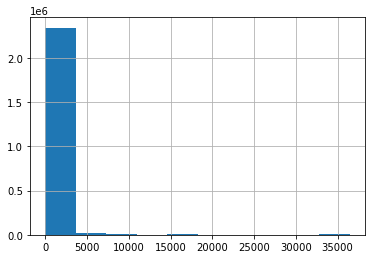

In [36]:
_ = wallets.num_sales.hist()

In [37]:
wallets.num_sales.agg(["min", "mean", "median", "max"]) 

min           0.000000
mean        258.286617
median        2.000000
max       36462.000000
Name: num_sales, dtype: float64

In [38]:
sum(wallets.num_sales.isna())

15654

In [39]:
wallets.num_sales.fillna(2, inplace=True)

## 莊惟翔 WIP

1. 限定數量為一(不算bundle) 2022/6/09

2. 將錢包地址分組

3. 暫時給定任一個錢包地址來進行以下特徵計算 (最後再用迴圈串起來)

_*Note to Fred:*_ 'quantity' has already been converted to float during the initial data load.

In [40]:
#2022/6/09
df_temp2 = wallets.drop(columns=["payment_token_usdprice", "asset_bundle","auction_type","transaction_hash", \
                       "block_hash","block_number","is_private","duration"])

#限定數量為一(不算bundle) 2022/6/09
df_temp2 = df_temp2[df_temp2['quantity'] == 1]
#將錢包地址分組
sectors = df_temp2.groupby("wallet_address_input")

#暫時給定任一個錢包地址來進行以下特徵計算 (最後再用迴圈串起來)
df_temp3 = sectors.get_group("0x5338035c008ea8c4b850052bc8dad6a33dc2206c")
df_temp3.reset_index(drop = True, inplace=True)
df_temp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5496 entries, 0 to 5495
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   event_timestamp       5496 non-null   datetime64[ns]
 1   event_type            5496 non-null   object        
 2   token_id              5496 non-null   object        
 3   num_sales             5496 non-null   float64       
 4   listing_time          5448 non-null   datetime64[ns]
 5   token_owner_address   5496 non-null   object        
 6   token_seller_address  5496 non-null   object        
 7   deal_price            5496 non-null   float64       
 8   payment_token_symbol  5496 non-null   object        
 9   quantity              5496 non-null   float64       
 10  created_date          5496 non-null   object        
 11  collection_slug       5496 non-null   object        
 12  contract_address      5496 non-null   object        
 13  wallet_address_inp

In [41]:
df_temp3.head()

,event_timestamp,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,deal_price,payment_token_symbol,quantity,created_date,collection_slug,contract_address,wallet_address_input,deal_price_usd
0,2022-05-04 03:29:18,buy,2977,1.0,2022-05-04 03:19:37,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x4984fc170325e8fe57e9de1c2b74ce5eabb6f9da,0.845,ETH,1.0,2022-05-04T03:29:50.900288,fragments-by-james-jean,0x7f268357a8c2552623316e2562d90e642bb538e5,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,2020.38655
1,2022-05-04 03:29:18,buy,3016,1.0,2022-05-04 00:14:49,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0xc293bc1602efeba837cb240c49476e1d3fe0fd98,0.845,ETH,1.0,2022-05-04T03:29:50.461508,fragments-by-james-jean,0x7f268357a8c2552623316e2562d90e642bb538e5,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,2020.38655
2,2022-05-04 03:29:18,buy,4956,1.0,2022-05-03 19:39:05,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0xe2fb909159dea75b1520c382ca102989cdd1a276,0.840,ETH,1.0,2022-05-04T03:29:50.009580,fragments-by-james-jean,0x7f268357a8c2552623316e2562d90e642bb538e5,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,2008.43160
3,2022-05-04 03:29:18,buy,5078,1.0,2022-05-04 01:40:56,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x8a45d09b2dbbf1657fb8c14561b6525443631d22,0.850,ETH,1.0,2022-05-04T03:29:49.627993,fragments-by-james-jean,0x7f268357a8c2552623316e2562d90e642bb538e5,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,2032.34150
4,2022-05-04 03:29:18,buy,5800,1.0,2022-05-04 02:52:43,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0xcc60f720388551bc9159cfed814a15de2f49d1e9,0.849,ETH,1.0,2022-05-04T03:29:49.240455,fragments-by-james-jean,0x7f268357a8c2552623316e2562d90e642bb538e5,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,2029.95051


In [42]:
#買入價格，給定以太鏈。Eth = deal_price/(10**18)
#df_temp3["cost"] = np.where(df_temp3["wallet_address_input"][0]==df_temp3["token_seller_address"], 0,df_temp3["deal_price"]/10**18)
df_temp3["cost"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], 0, df_temp3["deal_price"])
#賣出價格
#df_temp3["sellprice"] = np.where(df_temp3["wallet_address_input"][0]==df_temp3["token_seller_address"], df_temp3["deal_price"]/10**18, 0)
df_temp3["sellprice"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], df_temp3["deal_price"], 0)

## cost and sellprice probably aren't necessary since it can be infer from 'Buy_Sell' created below
## a deal_price_usd is recommended

#日期轉換
df_temp3["Datetime"] = pd.to_datetime(df_temp3["event_timestamp"]) # this can be stored in event_timestamp instead of a new column
#買賣戳記
# Consider overwriting event_type column
df_temp3["Buy_Sell"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], "S", 'B')
#投資組合(庫存) << what do we plan to store here?
df_temp3["Profolio"] = np.NaN
#損益 << Profit? How do we plan to calculate this for each row of event?
df_temp3["PL"] = 0
#token持有數量 << 
df_temp3["NFT_total_num"] = 0
#用collection_slug和tokenid組一個獨立欄位，用以紀錄錢包所持有的token
df_temp3["collection_slug_tokenid"] = df_temp3["collection_slug"] + df_temp3["token_id"]
#token從二級買進到賣出所持有的時間
df_temp3["HoldPeriod"] = np.NaN
df_temp3["Position"] = 0
df_temp3["Sell"] = 0

C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\2091787877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3["cost"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], 0, df_temp3["deal_price"])
C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\2091787877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3["sellprice"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], df_temp3["deal_price"], 0)
C:\Users\lawrence\AppData\Loc

In [43]:
df_temp3.iloc[:,15:].head()

,cost,sellprice,Datetime,Buy_Sell,Profolio,PL,NFT_total_num,collection_slug_tokenid,HoldPeriod,Position,Sell
0,0.845,0.0,2022-05-04 03:29:18,B,NaN,0,0,fragments-by-james-jean2977,NaN,0,0
1,0.845,0.0,2022-05-04 03:29:18,B,NaN,0,0,fragments-by-james-jean3016,NaN,0,0
2,0.840,0.0,2022-05-04 03:29:18,B,NaN,0,0,fragments-by-james-jean4956,NaN,0,0
3,0.850,0.0,2022-05-04 03:29:18,B,NaN,0,0,fragments-by-james-jean5078,NaN,0,0
4,0.849,0.0,2022-05-04 03:29:18,B,NaN,0,0,fragments-by-james-jean5800,NaN,0,0


In [44]:
df_temp3.iloc[:,15:].tail()

,cost,sellprice,Datetime,Buy_Sell,Profolio,PL,NFT_total_num,collection_slug_tokenid,HoldPeriod,Position,Sell
5491,0.000,4.6,2021-08-06 17:37:13,S,NaN,0,0,fortune-media1,NaN,0,0
5492,3.000,0.0,2021-08-06 16:10:08,B,NaN,0,0,fortune-media1,NaN,0,0
5493,0.001,0.0,2021-08-06 08:13:11,B,NaN,0,0,knightstory35613,NaN,0,0
5494,0.000,0.6,2021-08-06 06:06:29,S,NaN,0,0,rumble-kong-league3933,NaN,0,0
5495,0.070,0.0,2021-08-03 05:37:49,B,NaN,0,0,rumble-kong-league3933,NaN,0,0


Is the code block below attempting to calculate the _current cumulative stat_ of each wallet?

In [45]:
porfolio_dict = {}#紀錄持有的NFT集合
porfolio_costdict = {}#紀錄買入成本
porfolio_datedict = {}#紀錄買入時間
count = 0
error = []
#資料時間是從新到舊，計算時要倒序，從舊到新去累計上來。
for i in range(len(df_temp3)-1,-1,-1):
    #初次買進NFT項目
    if df_temp3["collection_slug"][i] not in porfolio_dict.keys():
        if df_temp3["Buy_Sell"][i]=="B":
            #庫存加一
            count = count+1
            porfolio_dict[df_temp3["collection_slug"][i]] = [df_temp3["token_id"][i]]
            df_temp3.loc[i, "Profolio"] = [porfolio_dict]
            df_temp3.loc[i, "NFT_total_num"] = count
            #NFT成本
            porfolio_costdict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["cost"][i]
            #NFT買進時間
            porfolio_datedict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["Datetime"][i]
            #position
            df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
            
        else:
            #賣出代表過去有可能發生來自於其他錢包轉移，但無法計算到先前持有的成本。
            df_temp3.loc[i, "NFT_total_num"] = count
            df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
    else:
        #手上持有此項目的NFT
        if df_temp3["token_id"][i] not in porfolio_dict[df_temp3["collection_slug"][i]]:
            if df_temp3["Buy_Sell"][i]=="B":
                #買進加碼
                porfolio_dict[df_temp3["collection_slug"][i]].append(df_temp3["token_id"][i])
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                #庫存加一
                count = count+1
                df_temp3.loc[i, "NFT_total_num"] = count
                #NFT成本
                porfolio_costdict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["cost"][i]
                #NFT買進時間
                porfolio_datedict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["Datetime"][i]
                #position
                df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
                
            else:
                #賣出。有可能發生來自於其他錢包轉移，但無法計算到先前持有的成本。
                df_temp3.loc[i, "NFT_total_num"] = count
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
        else:
            if df_temp3["Buy_Sell"][i]=="B":
                #不可能發生，因為tokenid是唯一的?
                df_temp3.loc[i, "NFT_total_num"] = count
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
            else:
                #損益發生點，完成一次買入跟賣出
                #庫存減一
                count = count-1
                df_temp3.loc[i, "NFT_total_num"] = count
                #將token從porfolio移除
                porfolio_dict[df_temp3["collection_slug"][i]].remove(df_temp3["token_id"][i])
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                if df_temp3["collection_slug_tokenid"][i] in porfolio_costdict.keys():
                    profit = df_temp3["sellprice"][i] - porfolio_costdict[df_temp3["collection_slug_tokenid"][i]]
                    df_temp3.loc[i, "PL"] =  profit        
                    #丟棄key and value因為賣出了
                    porfolio_costdict.pop(df_temp3["collection_slug_tokenid"][i])
                    df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
                    #TOKEN從買入到賣出持有間隔時間
                    date_substrate = df_temp3["Datetime"][i] - porfolio_datedict[df_temp3["collection_slug_tokenid"][i]]
                    df_temp3.loc[i, "HoldPeriod"] =  date_substrate
                    #賣出戳記
                    df_temp3.loc[i, "Sell"] =  1
                    
                else:
                    #通常不會到這裡
                    error.append([df_temp3["wallet_address_input"][0],df_temp3["collection_slug_tokenid"][i]])
                    df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                    df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())

C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\2146049416.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3.loc[i, "Profolio"] = [porfolio_dict]
C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\2146049416.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\2146049416.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [46]:
#損益為正
def positive_SIGN(row):
    if row['PL_sign'] == 1:
        return 1
    return 0

#損益為負
def negative_SIGN(row):
    if row['PL_sign'] == -1 :
        return 1
    return 0

In [47]:
#累計損益是在一個錢包裡完成完整的買進賣出動作所累計的。
df_temp3['cum_PL'] = df_temp3.loc[::-1, 'PL'].cumsum()[::-1]
#總利潤
df_temp3['TotalRevenue'] = df_temp3['cum_PL'] - df_temp3["Position"]
#損益正負符號
df_temp3["PL_sign"] = np.sign(list(df_temp3["PL"].values))
#累計賣出數量
df_temp3["cum_Sell"] = df_temp3.loc[::-1, 'Sell'].cumsum()[::-1]
#損益為正做記號
df_temp3["positive_sign"] = df_temp3.apply(lambda row: positive_SIGN(row), axis=1)
#損益為負做記號
df_temp3["negative_sign"] = df_temp3.apply(lambda row: negative_SIGN(row), axis=1)
#累積正損益數
df_temp3["cum_positive_sign"] = df_temp3.loc[::-1, 'positive_sign'].cumsum()[::-1]
#累積負損益數
df_temp3["cum_negative_sign"] = df_temp3.loc[::-1, 'negative_sign'].cumsum()[::-1]
#勝率
df_temp3["winrate"] = df_temp3["cum_positive_sign"] / df_temp3['cum_Sell']
#輸錢率
df_temp3["lossrate"] = df_temp3["cum_negative_sign"] / df_temp3['cum_Sell']
#用0填補缺值
df_temp3["winrate"] = df_temp3["winrate"].fillna(0)
df_temp3["lossrate"] = df_temp3["lossrate"].fillna(0)
#接受問價而賣出做紀號
df_temp3["Bid_sell"] = np.where((df_temp3["payment_token_symbol"]=="WETH")&(df_temp3["Buy_Sell"]=="S"), 1,0)
#透過問價而買入做紀號
df_temp3["Bid_buy"] = np.where((df_temp3["payment_token_symbol"]=="WETH")&(df_temp3["Buy_Sell"]=="B"), 1,0)
#累計問價買入數
df_temp3["cum_Bid_buy"] = df_temp3.loc[::-1, 'Bid_buy'].cumsum()[::-1]
#累計接受問價賣出數
df_temp3["cum_Bid_sell"] = df_temp3.loc[::-1, 'Bid_sell'].cumsum()[::-1]

#勝率(透過問價而買入&接受問價而賣出)前者代表很會釣魚，後者代表失去信心或是無法抵抗高價誘惑
df_temp3["Bid_sell_rate"] = df_temp3["cum_Bid_sell"] / df_temp3["cum_Sell"]
df_temp3["Bid_sell_rate"] = df_temp3["Bid_sell_rate"].fillna(0)
df_temp3["Bid_buy_rate"] = df_temp3["cum_Bid_buy"] / df_temp3["NFT_total_num"]
df_temp3["Bid_buy_rate"] = df_temp3["Bid_buy_rate"].fillna(0) #2022/06/09
#TOKEN賣出數/手上TOKEN持有數
df_temp3["sellposition_rate"] = df_temp3["cum_Sell"]/df_temp3["NFT_total_num"]

C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\333410565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3['cum_PL'] = df_temp3.loc[::-1, 'PL'].cumsum()[::-1]
C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\333410565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3['TotalRevenue'] = df_temp3['cum_PL'] - df_temp3["Position"]
C:\Users\lawrence\AppData\Local\Temp\ipykernel_40180\333410565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [48]:
df_temp3.describe().loc["mean"]

num_sales              92.133188
deal_price              0.594653
quantity                1.000000
deal_price_usd       1421.769568
cost                    0.167076
sellprice               0.427577
PL                     -0.007838
NFT_total_num         541.347344
Position              178.461581
Sell                    0.099163
cum_PL                 42.507070
TotalRevenue         -135.954511
PL_sign                 0.018559
cum_Sell              225.277838
positive_sign           0.058770
negative_sign           0.040211
cum_positive_sign     161.560771
cum_negative_sign      63.649381
winrate                 0.755897
lossrate                0.243795
Bid_sell                0.008552
Bid_buy                 0.000182
cum_Bid_buy             0.280568
cum_Bid_sell           21.393741
Bid_sell_rate           0.131849
Bid_buy_rate            0.000258
sellposition_rate            inf
Name: mean, dtype: float64

## Create features

In [49]:
wallets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398450 entries, 0 to 2398449
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype          
---  ------                  --------------    -----          
 0   event_timestamp         2398450 non-null  datetime64[ns] 
 1   event_type              2398450 non-null  object         
 2   token_id                2382796 non-null  object         
 3   num_sales               2398450 non-null  float64        
 4   listing_time            2268796 non-null  datetime64[ns] 
 5   token_owner_address     2382796 non-null  object         
 6   token_seller_address    2395806 non-null  object         
 7   deal_price              2398445 non-null  float64        
 8   payment_token_symbol    2398411 non-null  object         
 9   payment_token_usdprice  2397937 non-null  float64        
 10  quantity                2398450 non-null  float64        
 11  asset_bundle            15675 non-null    object         
 12  

### wallet age

In [50]:
grp=wallets.rename(columns={"wallet_address_input": "user_account_address"}) \
    .groupby("user_account_address")
grp.agg({"event_timestamp": [max, min]}) \
    .assign(age=lambda x : x.loc[:, ("event_timestamp", "max")] - x.loc[:, ("event_timestamp", "min")]) \
    .sort_values(by=["age", ("event_timestamp", "min")])

event_timestamp  \
                                                           max   
user_account_address                                             
0x100815508fa1a6ffb4da16b21ab5f9e0d8d44329 2021-07-07 22:53:39   
0x87d43e13e583afe5414182024b36af6b034e86a3 2021-07-10 04:35:56   
0x9acb0539f2ea0c258ac43620dd03ef01f676a69b 2021-07-12 00:16:32   
0x2bed2ce9eb28db3c66a33aad4fa4631fcae0f047 2021-07-12 06:59:25   
0x1b748e0474056e436dec36136aea86c0f46ee518 2021-07-26 14:40:22   
...                                                        ...   
0xd1bea81dd97d4fcebc5b25686bdca04deff3991f 2022-05-10 02:01:13   
0x30602250c5f1fcba5407e99b1dfaab992ea4ffd2 2022-05-09 18:31:04   
0x44cd75d0eccac283c62184ef87626d639e047441 2022-05-04 17:31:49   
0x7132c9f36abe62eab74cdfdd08c154c9ae45691b 2022-02-23 23:32:29   
0x6f4a2d3a4f47f9c647d86c929755593911ee91ec 2022-04-25 16:10:15   

                                                                \
                                                           min   
user_account_address                                             
0x100815508fa1a6ffb4da16b21ab5f9e0d8d44329 2021-07-07 22:53:39   
0x87d43e13e583afe5414182024b36af6b034e86a3 2021-07-10 04:35:56   
0x9acb0539f2ea0c258ac43620dd03ef01f676a69b 2021-07-12 00:16:32   
0x2bed2ce9eb28db3c66a33aad4fa4631fcae0f047 2021-07-12 06:59:25   
0x1b748e0474056e436dec36136aea86c0f46ee518 2021-07-26 14:40:22   
...                                                        ...   
0xd1bea81dd97d4fcebc5b25686bdca04deff3991f 2017-12-01 01:55:52   
0x30602250c5f1fcba5407e99b1dfaab992ea4ffd2 2017-11-28 21:40:39   
0x44cd75d0eccac283c62184ef87626d639e047441 2017-11-23 18:53:37   
0x7132c9f36abe62eab74cdfdd08c154c9ae45691b 2017-07-12 01:14:03   
0x6f4a2d3a4f47f9c647d86c929755593911ee91ec 2017-07-04 04:33:49   

                                                          age  
                                                               
user_account_address                                           
0x100815508fa1a6ffb4da16b21ab5f9e0d8d44329    0 days 00:00:00  
0x87d43e13e583afe5414182024b36af6b034e86a3    0 days 00:00:00  
0x9acb0539f2ea0c258ac43620dd03ef01f676a69b    0 days 00:00:00  
0x2bed2ce9eb28db3c66a33aad4fa4631fcae0f047    0 days 00:00:00  
0x1b748e0474056e436dec36136aea86c0f46ee518    0 days 00:00:00  
...                                                       ...  
0xd1bea81dd97d4fcebc5b25686bdca04deff3991f 1621 days 00:05:21  
0x30602250c5f1fcba5407e99b1dfaab992ea4ffd2 1622 days 20:50:25  
0x44cd75d0eccac283c62184ef87626d639e047441 1622 days 22:38:12  
0x7132c9f36abe62eab74cdfdd08c154c9ae45691b 1687 days 22:18:26  
0x6f4a2d3a4f47f9c647d86c929755593911ee91ec 1756 days 11:36:26  

[9766 rows x 3 columns]

_Do we ingore wallet age is 0 and over x months old?_

### `duration_mean` average time to complete sales (or purchase)

In [51]:
wallets.groupby('wallet_address_input')['duration'].mean().sort_values()

wallet_address_input
0xf58dea7581b336582b806c99a9bc6c36363ce85b               0 days 00:00:00
0x301061233dac5b45e7809e12a0e7eef5b6385167               0 days 00:00:00
0x34303439ebf97dcd03f38312cdab442cdb3d339b               0 days 00:00:00
0x0945198dd98c78d88568004d775e33800cfe4bfa               0 days 00:00:00
0xde2c53d02c7374526ce25c061220a440114f3d1c               0 days 00:00:00
                                                         ...            
0xeb5806ffcf9a1e9b24876b68dab80c4dd7ef42ec    94 days 02:47:03.090909091
0xe16dd613ba42537f8bb071995fcc438eb006541e   102 days 10:49:34.846153846
0x6022ec04885f671818a4ff7426908e17022e5e29   103 days 06:53:59.761904762
0x1b6284b63ad8e0b0e254500869896153a2260d1c   117 days 22:31:04.886761032
0x530cf036ed4fa58f7301a9c788c9806624cefd19   211 days 10:24:05.242249668
Name: duration, Length: 9766, dtype: timedelta64[ns]

### `duration_colection_mean` average time to complete sales (or purchase) by collection

In [52]:
wallets.groupby(['wallet_address_input', 'collection_slug'])['duration'].mean().sort_values()

wallet_address_input                        collection_slug       
0x78da045905af93e584c86dc882851ea95fbc6576  letswalk                           0 days 00:00:00
0x3050210b35626472d652c05d37db80f8f65f1b4d  fvck-avatar-essence                0 days 00:00:00
0x54becc7560a7be76d72ed76a1f5fee6c5a2a7ab6  rarible                            0 days 00:00:00
0xea88d663e8cc803be8713199437355ee50f68ebf  decentraland-wearables             0 days 00:00:00
0xe1ff19610020d72930aee1b9c047e35b7fd0080e  skillett-souls                     0 days 00:00:00
                                                                                ...           
0x35a214b13c9e223b8d511f343ac8fa94293233a1  qwoyn-dappcaps                  1038 days 04:57:04
0xbe39ad6d10802b6ac0943eab3e6c6b1884a054c4  cryptocrystal                   1055 days 15:35:56
0x6022ec04885f671818a4ff7426908e17022e5e29  eth-town                 1060 days 00:01:19.500000
0xfe5573c66273313034f7ff6050c54b5402553716  cryptocrystal                   11

### `num_nft_curr` currently the number of NFT on-hand by collection

In [53]:
_ = wallets.loc[:, ['wallet_address_input', 'event_type', 'collection_slug', 'token_id', 'quantity']]
_.quantity = np.where(_.event_type == 'buy', -_.quantity, _.quantity)
_ = _.rename(columns={'wallet_address_input': 'user_account_address'}) \
    .groupby(['user_account_address', 'collection_slug'])['quantity'].sum()
_[_ < 1]

user_account_address                        collection_slug           
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4  blox-blu                     -1.0
                                            cool-cats-nft                -1.0
                                            coolpetsnft                  -3.0
                                            doodles-official             -2.0
                                            fishyfam                     -4.0
                                                                         ... 
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c  coolpetsnft                   0.0
                                            metaangelsnft                -1.0
                                            white-rabbit-producer-pass   -1.0
0xffffc32855b2620c86f413065af8c58ec68d474d  baby-duck-incubator          -1.0
                                            wrapped-mooncatsrescue       -1.0
Name: quantity, Length: 365842, dtype: float64

We drop data anomaly where current number is less than 1, or should we make impute them to `0`?

In [54]:
_ = _[_ >= 1]
_

user_account_address                        collection_slug      
0x000000000ad266ec3db44bbe580e87f9baa358e6  coolpetsnft               3.0
                                            corruption-s              1.0
                                            creatureworld             1.0
                                            doodles-official          1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7  heartnfts                 1.0
                                                                     ... 
0xffffc32855b2620c86f413065af8c58ec68d474d  sail-o-bots-by-sturec     1.0
                                            sandbox                  49.0
                                            timelessnfts              4.0
                                            treeverse-plots           2.0
                                            wavesonchain              1.0
Name: quantity, Length: 206115, dtype: float64

### `num_collect_curr` currently the number of collections on-hand

In [55]:
_.groupby('user_account_address').size()

user_account_address
0x000000000ad266ec3db44bbe580e87f9baa358e6     4
0x0004ff7e7217dc672874fece2c7588581e97b1a7     2
0x000cd27f10dffac73201258eaa3925c0452051a0    32
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b    33
0x001096190e8f3fa24b749704be231ab232348cb1     8
                                              ..
0xffea8516005b365fe9cb43393c74c3965c98c164     2
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737     2
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1     8
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c     3
0xffffc32855b2620c86f413065af8c58ec68d474d    15
Name: quantity, Length: 8608, dtype: int64

### `num_event_contracts`

How do we make use of this feature?

In [56]:
wallets.groupby('wallet_address_input')[['contract_address', 'collection_slug']].nunique().sort_values('contract_address')

,contract_address,collection_slug
wallet_address_input,,
0x828d5676c11814573d004451b003218b8982bcb9,1,51
0x65f8cbe68e5a9127b28f43ffc55518400d05d032,1,9
0xd185e7e5e3a95e723736e2825ba0c2e9447f19d4,1,33
0xd1761d41509c8777cdee4a5a298c687ae736df3a,1,7
0xd1667c7f76bb120561959c3b2b5fb9ec9b0a6bf2,1,8
...,...,...
0x0239769a1adf4def9f07da824b80b9c4fcb59593,15,123
0x6e63a4caeccb4f341ee9c9175c9cc554bdb6d10b,16,306
0x3401ea5a8d91c5e3944962c0148b08ac4a77f153,18,411


### `cumnum_nft_month` pd.DataFrame.cumsum by Month (TODO)

### `duration_held` and `endurance_rank`

In [57]:
_ = wallets.loc[:, ['wallet_address_input', 'event_timestamp', 'event_type', 'collection_slug', 'token_id']]
#_['nft_id'] = _.collection_slug + '-' + _.token_id
_ = _.pivot_table(index=['wallet_address_input', 'collection_slug', 'token_id'],
                  columns='event_type', values='event_timestamp',
                  aggfunc=['min', 'max']) \
    .dropna() \
    .assign(duration_held=lambda x: x[('max', 'sell')] - x[('min', 'buy')])
_

min  \
event_type                                                                             buy   
wallet_address_input                       collection_slug    token_id                       
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4 doodles-official   6328     2021-10-18 13:26:32   
                                                              6680     2021-10-18 22:06:44   
                                                              7683     2021-10-19 07:13:31   
                                           genzee             7917     2021-10-14 23:26:57   
0x0004ff7e7217dc672874fece2c7588581e97b1a7 acclimatedmooncats 6343     2021-09-14 02:41:49   
...                                                                                    ...   
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1 ethterrestrials    2961     2022-04-01 16:41:44   
                                                              3918     2022-04-01 16:41:44   
                                                              681      2022-04-01 16:41:44   
                                                              729      2022-04-01 16:41:44   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c coolpetsnft        16912    2022-03-01 08:35:16   

                                                                                            \
event_type                                                                            sell   
wallet_address_input                       collection_slug    token_id                       
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4 doodles-official   6328     2021-11-16 07:30:18   
                                                              6680     2021-11-16 18:02:51   
                                                              7683     2021-12-28 15:48:50   
                                           genzee             7917     2021-11-22 18:41:53   
0x0004ff7e7217dc672874fece2c7588581e97b1a7 acclimatedmooncats 6343     2022-02-12 03:07:49   
...                                                                                    ...   
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1 ethterrestrials    2961     2022-04-11 03:34:30   
                                                              3918     2022-04-09 01:12:51   
                                                              681      2022-04-08 23:59:25   
                                                              729      2022-04-08 23:59:25   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c coolpetsnft        16912    2022-03-28 06:26:32   

                                                                                       max  \
event_type                                                                             buy   
wallet_address_input                       collection_slug    token_id                       
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4 doodles-official   6328     2021-10-18 13:26:32   
                                                              6680     2021-10-18 22:06:44   
                                                              7683     2021-10-19 07:13:31   
                                           genzee             7917     2021-10-14 23:26:57   
0x0004ff7e7217dc672874fece2c7588581e97b1a7 acclimatedmooncats 6343     2021-09-14 02:41:49   
...                                                                                    ...   
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1 ethterrestrials    2961     2022-04-01 16:41:44   
                                                              3918     2022-04-01 16:41:44   
                                                              681      2022-04-01 16:41:44   
                                                              729      2022-04-01 16:41:44   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c coolpetsnft        16912    2022-03-01 08:35:16   

                                                                                            \
event_type                                

In [58]:
x = _.groupby('wallet_address_input')['duration_held'] \
    .agg(['size', 'mean'])
x

,size,mean
wallet_address_input,,
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4,4,41 days 16:27:32
0x0004ff7e7217dc672874fece2c7588581e97b1a7,8,40 days 01:47:50.125000
0x000cd27f10dffac73201258eaa3925c0452051a0,32,26 days 16:22:07.718750
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b,245,69 days 14:33:29.665306122
0x001096190e8f3fa24b749704be231ab232348cb1,35,17 days 16:19:07.914285714
...,...,...
0xffd971d72f77fefcee7f450eb90a828296e6fd6f,43,22 days 00:01:30.744186046
0xffea8516005b365fe9cb43393c74c3965c98c164,7,81 days 20:50:39.285714286
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737,1,119 days 05:02:06


Data anomaly - excluding these wallets

In [59]:
x[x['mean'] < pd.Timedelta(0)]

,size,mean
wallet_address_input,,
0x229fd4fc7ca05e61d626ea0d8fe2622ab01fcf6f,2,-10 days +22:28:51
0x25c4c714a1977946aa9e5ca7b640f29511365234,3,-30 days +12:29:47.333333334
0x38bc41b2a3a3543e3d400a5c24f404335a1feae6,8,-13 days +02:24:10.500000
0x5480259e435fa36e098601525aa1d60defd43a2f,1,-11 days +07:38:23
0x66af4d4f0a18e95a804cfc3852ff6f54d8bf2867,1,-28 days +21:06:05
0x7841c102d8d13c1f78c0d942e73117cdc6119697,1,-1 days +23:58:32
0xa81eac3009bd6e6cce36602d6851fda789ddc3bb,18,-71 days +13:42:00.666666667
0xac06d32f100d50ca67f290307ec590443d639c8e,17,-3 days +10:21:58.705882353
0xae883438e3ac3978e9bae7ea2a12f2137d132ade,2,-36 days +15:48:38


In [60]:
x[x['mean'] > pd.Timedelta(0)] \
    .assign(endurance_rank=lambda x: x['mean'].rank(pct=True)) \
    .sort_values('endurance_rank', ascending=False)

,size,mean,endurance_rank
wallet_address_input,,,
0x81745b7339d5067e82b93ca6bbad125f214525d3,1,913 days 23:55:03,1.000000
0x11f7d9f08d7b548b0a0ec8329de0994fc0c7dbbd,2,615 days 06:28:45.500000,0.999875
0x87ee05fcc5b0290e2fbf6e3c68b65b6e572bed36,4,485 days 18:40:14.250000,0.999750
0xaa52c6d3e260d22bace717201682bc9c5a5b203d,6,418 days 18:58:47.166666664,0.999625
0x51787a2c56d710c68140bdadefd3a98bff96feb4,75,408 days 22:00:21.480000,0.999500
...,...,...,...
0x4898203e852b3ed44cc3e8d37f702fd0a7bdac9a,1,0 days 00:08:23,0.000625
0xdbb857aa54c7a8dd29e73eef7edcbe6b757f9160,1,0 days 00:06:15,0.000500
0xe16dd613ba42537f8bb071995fcc438eb006541e,5,0 days 00:06:08.800000,0.000375


\* _How do we account for wallets that had made few trade but long hold time?_

### _buy_ vs _sell_ to date

- The total number aka __count__ of transactions and the quantity aka __sum__ of NFT
- The median and the total amount of transactions in USD

In [61]:
df = wallets.rename(columns={"wallet_address_input": "user_account_address"}) \
    .loc[:, ["user_account_address", "event_type", "quantity", "deal_price_usd"]] \
    .pivot_table(index="user_account_address",
                 columns="event_type",
                 values=["quantity", "deal_price_usd"],
                 aggfunc={"quantity": ["count", "sum"], "deal_price_usd": ["median", "sum"]},
                 fill_value=0)
df

deal_price_usd                \
                                                   median                 
event_type                                            buy          sell   
user_account_address                                                      
0x000000000ad266ec3db44bbe580e87f9baa358e6       0.000000   2702.150010   
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4     382.481300   6412.186500   
0x0004ff7e7217dc672874fece2c7588581e97b1a7    1805.096000   1866.051000   
0x000cd27f10dffac73201258eaa3925c0452051a0    3436.776000   3699.307500   
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b     696.204000    438.144384   
...                                                   ...           ...   
0xffea8516005b365fe9cb43393c74c3965c98c164    3114.355200   2878.419200   
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737    2365.496352  12236.563350   
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1    6979.553000   2739.415000   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c    3542.010000   3707.303800   
0xffffc32855b2620c86f413065af8c58ec68d474d     342.143925  17131.206350   

                                                                         \
                                                      sum                 
event_type                                            buy          sell   
user_account_address                                                      
0x000000000ad266ec3db44bbe580e87f9baa358e6       0.000000  4.095254e+04   
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4   64787.832440  8.500084e+04   
0x0004ff7e7217dc672874fece2c7588581e97b1a7   78736.313924  8.120149e+04   
0x000cd27f10dffac73201258eaa3925c0452051a0  546134.496014  8.387385e+05   
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b  553868.717341  5.850186e+05   
...                                                   ...           ...   
0xffea8516005b365fe9cb43393c74c3965c98c164   43430.391072  4.863821e+04   
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737  165556.994076  2.258968e+05   
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1  815502.485340  1.143758e+06   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c   23410.324760  2.148583e+04   
0xffffc32855b2620c86f413065af8c58ec68d474d     684.287850  8.936445e+05   

                                           quantity                     
                                              count         sum         
event_type                                      buy sell    buy   sell  
user_account_address                                                    
0x000000000ad266ec3db44bbe580e87f9baa358e6        0    6    0.0    6.0  
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4       34    5   34.0    5.0  
0x0004ff7e7217dc672874fece2c7588581e97b1a7       21   12   47.0   16.0  
0x000cd27f10dffac73201258eaa3925c0452051a0       59   78   59.0   78.0  
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b      309  436  311.0  445.0  
...                                             ...  ...    ...    ...  
0xffea8516005b365fe9cb43393c74c3965c98c164       15    9   15.0    9.0  
0xffeafbc24c7f8736d682f49d1bf3b023a39aa737       45    4   48.0    4.0  
0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1       37   42   37.0   42.0  
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c        5    5    5.0    5.0  
0xffffc32855b2620c86f413065af8c58ec68d474d        2   40    2.0   82.0  

[9766 rows x 8 columns]

Examples which user had _bundled_ multitple NFTs in a transaction

In [62]:
df[ df[("quantity", "sum", "sell")] > df[("quantity", "count", "sell")] ].loc[:, "quantity"]

count         sum       
event_type                                   buy sell    buy   sell
user_account_address                                               
0x0004ff7e7217dc672874fece2c7588581e97b1a7    21   12   47.0   16.0
0x000f9aa9783be4d2955faca0f9a4d3c676fc9e0b   309  436  311.0  445.0
0x0015b091ba5d9b3a7a84b77bc33007b1f4700dc7   115   61  115.0   67.0
0x00668bd79ede077b99bbe1c4db59418bc333d4cf   709  482  728.0  529.0
0x00845d3a8773c9323a1046d9fa885917f39987ba   113  313  114.0  314.0
...                                          ...  ...    ...    ...
0xff9911abdbe9d1f7d1a19595b93905c2a9ad60f4   577  596  587.0  597.0
0xffacee28004c857ef41a8b6ebd82e8c6d2c68355    32   21   32.0   22.0
0xffaeb8245a90057fe513f45ef571e102788fd71d    13   21   13.0   22.0
0xffce09ca00041e196e10458d5f981c0a1a76fe98   105  127  109.0  128.0
0xffffc32855b2620c86f413065af8c58ec68d474d     2   40    2.0   82.0

[2610 rows x 4 columns]

Another example showing the transaction history

In [63]:
wallets.set_index("wallet_address_input") \
    .loc["0x0004ff7e7217dc672874fece2c7588581e97b1a7",
    ["event_timestamp", "event_type", "quantity"]].sort_values("event_timestamp")

,event_timestamp,event_type,quantity
wallet_address_input,,,
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-08-23 11:14:45,buy,13.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-08-28 05:07:43,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-08-30 11:36:41,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-08-31 14:24:37,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-09 13:19:26,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-09 18:42:46,sell,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-14 02:41:49,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-15 18:25:36,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-16 05:26:44,buy,1.0


### `cashflow` and `cashflow_usd` as a simple method to calculate profit



In [64]:
wallets["cashflow"] = np.where(wallets.event_type == "buy",
                                -wallets.deal_price,
                                 wallets.deal_price)
wallets["cashflow_usd"] = np.where(wallets.event_type == "buy",
                                -wallets.deal_price_usd,
                                 wallets.deal_price_usd)
wallets.loc[:, ["event_type", "cashflow", "cashflow_usd"]]

,event_type,cashflow,cashflow_usd
0,sell,4.500,10786.09500
1,buy,-1.100,-2636.60100
2,buy,-1.000,-2396.91000
3,buy,-0.098,-234.89718
4,buy,-0.240,-575.25840
...,...,...,...
2398445,buy,-0.249,-585.74511
2398446,buy,-0.150,-352.85850
2398447,buy,-0.100,-235.23900
2398448,buy,-0.725,-1705.48275


Example: January 2020 cash flow

In [65]:
wallets.set_index('event_timestamp') \
    .loc['2022-01'] \
    .groupby(['wallet_address_input', 'payment_token_symbol']) \
    [['cashflow', 'cashflow_usd']].sum() \
    .sort_values(by=['cashflow_usd', 'cashflow'], ascending=False)

,,cashflow,cashflow_usd
wallet_address_input,payment_token_symbol,,
0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,ETH,2.177497e+03,5.251579e+06
0xb3ee5011a7965905cde351ea4905ff4725189a3b,ETH,1.415896e+03,3.285134e+06
0x69bab6810fa99475854bca0a3dd72ae6a0728ece,ETH,1.347965e+03,3.128196e+06
0x7a9fe22691c811ea339d9b73150e6911a5343dca,SAND,1.272359e+06,2.341140e+06
0x296df88601c8f49535f881de73684d5e2d530a71,ETH,9.162500e+02,2.122365e+06
...,...,...,...
0x0743882fa09a0c257b18d53dc1b101d3f32a04e5,ETH,-8.906932e+02,-2.051489e+06
0xf142d7baff0986b50ae24e694419c65e7091f52c,ETH,-9.117243e+02,-2.094459e+06
0x0ed1e02164a2a9fad7a9f9b5b9e71694c3fad7f2,ETH,-9.453803e+02,-2.171775e+06


To calculate cash flow by collection: `groupby(['wallet_address_input', 'payment_token_symbol', 'collection_slug'])`

Big Trader?

In [66]:
wallets.loc[wallets.wallet_address_input == "0x17082a8fbae3c10d73a361f218ae77bafb62bf4d"]

,event_timestamp,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,deal_price,payment_token_symbol,payment_token_usdprice,...,block_number,is_private,duration,created_date,collection_slug,contract_address,wallet_address_input,deal_price_usd,cashflow,cashflow_usd
1201371,2022-04-06 00:54:29,sell,4388,1.0,2022-03-30 10:27:09,0x6b3dc13a94a526131a9c0aaeec53abf8da266e82,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,1.420690,ETH,2411.75,...,14529260.0,0.0,6 days 14:27:20,2022-04-06T00:54:40.533107,vogu,0x7f268357a8c2552623316e2562d90e642bb538e5,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,3426.349108,1.420690,3426.349108
1201372,2022-03-24 19:50:58,sell,5490,2.0,NaT,0x4714701542b52ee59dde2e4e4c468051c0b433da,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,1.300000,WETH,2407.05,...,14450966.0,NaN,0 days 00:00:00,2022-03-24T19:51:13.098731,nuclear-nerds-of-the-accidental-apocalypse,0x7f268357a8c2552623316e2562d90e642bb538e5,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,3129.165000,1.300000,3129.165000
1201373,2022-03-12 10:03:31,sell,8949,1.0,2022-03-12 02:02:49,0xaffaf00ca01772d27b503dcf0b935daecd57345b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,1.500000,ETH,2411.75,...,14371303.0,0.0,0 days 08:00:42,2022-03-12T10:03:54.143727,partybear,0x7f268357a8c2552623316e2562d90e642bb538e5,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,3617.625000,1.500000,3617.625000
1201374,2022-03-09 23:25:27,sell,5488,2.0,2022-03-09 22:57:32,0xa6c5112a3eb52595ddba5bb1eb5a3d1719d9ad63,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,1.800000,ETH,2411.75,...,14355572.0,0.0,0 days 00:27:55,2022-03-09T23:25:43.913823,nuclear-nerds-of-the-accidental-apocalypse,0x7f268357a8c2552623316e2562d90e642bb538e5,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,4341.150000,1.800000,4341.150000
1201375,2022-03-06 21:01:55,sell,4709,2.0,2022-03-06 19:44:12,0x330c086f7c2d812aa9044ba986314c9aa6e79619,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,0.790000,ETH,2411.75,...,14335589.0,0.0,0 days 01:17:43,2022-03-06T21:02:06.426126,nuclear-nerds-of-the-accidental-apocalypse,0x7f268357a8c2552623316e2562d90e642bb538e5,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,1905.282500,0.790000,1905.282500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203704,2021-06-21 17:41:13,buy,5721,2.0,2021-06-21 15:52:48,0x8205ecc26495ff55e1d6d84f59bd82c2dddd646d,0x2868a996089ebee1ed1d9e56a373398a907c2da3,0.145000,ETH,2411.75,...,12679046.0,0.0,0 days 01:48:25,2021-06-21T17:41:44.451894,myfuckingpickle,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,349.703750,-0.145000,-349.703750
1203705,2021-06-21 17:36:17,buy,5618,2.0,2021-06-21 17:02:16,0x94e321abab06df75089cd17c2e3dad9900170cff,0xa848e0a67ddbe7c3d62c578cc1a6873af140dfd7,1.450000,ETH,2411.75,...,12679022.0,0.0,0 days 00:34:01,2021-06-21T17:36:49.470569,bored-ape-kennel-club,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,3497.037500,-1.450000,-3497.037500
1203706,2021-06-21 17:34:39,buy,7326,4.0,2021-06-21 17:20:58,0xd69f5548fea54fb8578b9cc747b6b69e9200d349,0x6b557b76cdf5d5587df437a6d49833050c3b1d8f,1.450000,ETH,2411.75,...,12679013.0,0.0,0 days 00:13:41,2021-06-21T17:35:07.224704,bored-ape-kennel-club,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,3497.037500,-1.450000,-3497.037500
1203707,2021-06-21 17:32:41,buy,2588,4.0,2021-06-21 17:13:26,0x9a5c38bcbd07e274fd69f11d614b3b6ee19463ba,0xccd6cbffb071304eca69dd591c2d7df579182e19,1.430000,ETH,2411.75,...,12679007.0,0.0,0 days 00:19:15,2021-06-21T17:33:00.662800,bored-ape-kennel-club,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,3448.802500,-1.430000,-3448.802500


### `profit` (TODO)

### `win_lost_cnt` and `win_lost_pct` Win-Lost counts and ratio (TODO)

# Explore Data

## Daily Price and Volume (WIP)

We define
* Price as the minimum `deal price`
* Volume as either the total `deal_price` or total number of asset events, i.e. exchange frequency 

Todo: define the ceilings and floors for each FOMO wave, i.e. period

In [67]:
grp_cool_cats_nft=wallets.query('collection_slug == "cool-cats-nft" & deal_price > 0') \
    .groupby(pd.Grouper(key='event_timestamp', freq='1D'))

In [68]:
grp=wallets.query('deal_price > 0') \
    .groupby(pd.Grouper(key='event_timestamp', freq='1D'))

In [69]:
df = grp_cool_cats_nft.agg({"deal_price": ["sum", "mean", "median", "min"], "event_type": "count"}) \
        .assign(event_type_cnt_median=lambda x: x[('event_type', 'count')].median(),
                sum_pct_chg=lambda x: x[("deal_price", "sum")].pct_change(),
                min_pct_chg=lambda x: x[("deal_price", "min")].pct_change(),
                cnt_pct_chg=lambda x: x[("event_type", "count")].pct_change()) \
        .assign(sum_pp_diff=lambda x: x['sum_pct_chg'].diff(),
                min_pp_diff=lambda x: x['min_pct_chg'].diff(),
                cnt_pp_diff=lambda x: x['cnt_pct_chg'].diff())
df

deal_price                           event_type  \
                        sum      mean  median     min      count   
event_timestamp                                                    
2021-07-01         7.972998  0.032676  0.0180  0.0050        244   
2021-07-02       103.880795  0.073779  0.0300  0.0119       1408   
2021-07-03        44.310178  0.071353  0.0274  0.0190        621   
2021-07-04       392.749039  0.133045  0.0800  0.0100       2952   
2021-07-05       109.861423  0.176343  0.1000  0.0300        623   
...                     ...       ...     ...     ...        ...   
2022-05-06        97.099000  5.110474  5.1000  4.3000         19   
2022-05-07       124.337000  5.920810  4.8000  3.6020         21   
2022-05-08       117.169190  5.094313  4.5000  3.9000         23   
2022-05-09       111.943800  4.477752  4.0000  3.3000         25   
2022-05-10        45.152600  4.104782  4.0000  3.0030         11   

                event_type_cnt_median sum_pct_chg min_pct_chg cnt_pct_chg  \
                                                                            
event_timestamp                                                             
2021-07-01                       45.5         NaN         NaN         NaN   
2021-07-02                       45.5   12.029077    1.380000    4.770492   
2021-07-03                       45.5   -0.573452    0.596639   -0.558949   
2021-07-04                       45.5    7.863630   -0.473684    3.753623   
2021-07-05                       45.5   -0.720276    2.000000   -0.788957   
...                               ...         ...         ...         ...   
2022-05-06                       45.5   -0.440484    0.018475   -0.424242   
2022-05-07                       45.5    0.280518   -0.162326    0.105263   
2022-05-08                       45.5   -0.057648    0.082732    0.095238   
2022-05-09                       45.5   -0.044597   -0.153846    0.086957   
2022-05-10                       45.5   -0.596649   -0.090000   -0.560000   

                sum_pp_diff min_pp_diff cnt_pp_diff  
                                                     
event_timestamp                                      
2021-07-01              NaN         NaN         NaN  
2021-07-02              NaN         NaN         NaN  
2021-07-03       -12.602528   -0.783361   -5.329441  
2021-07-04         8.437082   -1.070323    4.312572  
2021-07-05        -8.583906    2.473684   -4.542580  
...                     ...         ...         ...  
2022-05-06         0.003987    0.013237    0.051948  
2022-05-07         0.721002   -0.180800    0.529506  
2022-05-08        -0.338166    0.245057   -0.010025  
2022-05-09         0.013051   -0.236578   -0.008282  
2022-05-10        -0.552052    0.063846   -0.646957  

[314 rows x 12 columns]

In [70]:
df.sort_values(('event_type', 'count'))

deal_price                          event_type  \
                         sum      mean median     min      count   
event_timestamp                                                    
2022-04-10         75.466000  9.433250  8.150  7.7500          8   
2021-12-06         62.907400  7.863425  7.375  6.7000          8   
2021-12-05         68.590000  8.573750  8.125  7.0000          8   
2021-12-04         94.810000  9.481000  8.825  7.8000         10   
2022-04-09         96.770000  9.677000  8.495  8.2500         10   
...                      ...       ...    ...     ...        ...   
2021-07-09        952.733679  0.864550  0.600  0.0970       1102   
2021-08-28       8040.980304  5.938686  5.000  2.5000       1354   
2021-07-02        103.880795  0.073779  0.030  0.0119       1408   
2021-07-07       1467.603462  0.553186  0.440  0.0480       2653   
2021-07-04        392.749039  0.133045  0.080  0.0100       2952   

                event_type_cnt_median sum_pct_chg min_pct_chg cnt_pct_chg  \
                                                                            
event_timestamp                                                             
2022-04-10                       45.5   -0.220151   -0.060606   -0.200000   
2021-12-06                       45.5   -0.082849   -0.042857    0.000000   
2021-12-05                       45.5   -0.276553   -0.102564   -0.200000   
2021-12-04                       45.5   -0.526211    0.115880   -0.600000   
2022-04-09                       45.5   -0.344554   -0.017857   -0.375000   
...                               ...         ...         ...         ...   
2021-07-09                       45.5    1.925600    1.025052    1.244399   
2021-08-28                       45.5   29.057971    0.176471   15.313253   
2021-07-02                       45.5   12.029077    1.380000    4.770492   
2021-07-07                       45.5    7.797788    0.371429    2.649243   
2021-07-04                       45.5    7.863630   -0.473684    3.753623   

                sum_pp_diff min_pp_diff cnt_pp_diff  
                                                     
event_timestamp                                      
2022-04-10         0.124403   -0.042749    0.175000  
2021-12-06         0.193704    0.059707    0.200000  
2021-12-05         0.249657   -0.218444    0.400000  
2021-12-04        -0.428887    0.133484   -0.525926  
2022-04-09         0.157267   -0.023845    0.125000  
...                     ...         ...         ...  
2021-07-09         2.703705    1.027136    2.059326  
2021-08-28        29.187785    0.119257   15.448670  
2021-07-02              NaN         NaN         NaN  
2021-07-07         7.279375    0.204762    2.482309  
2021-07-04         8.437082   -1.070323    4.312572  

[314 rows x 12 columns]

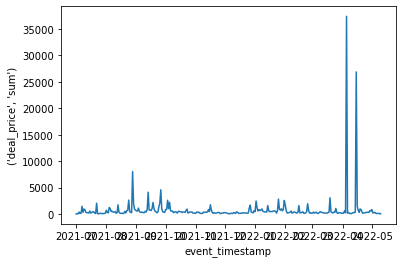

In [71]:
_ = sns.lineplot(data=df, x='event_timestamp', y=('deal_price', 'sum'))

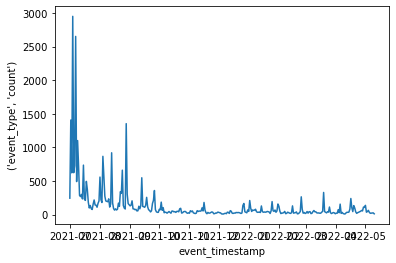

In [72]:
_ = sns.lineplot(data=df, x='event_timestamp', y=('event_type', 'count'))

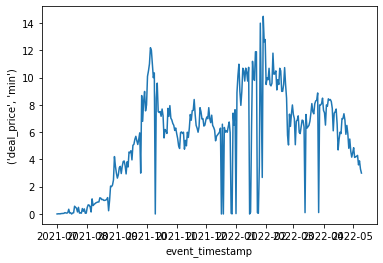

In [73]:
_ = sns.lineplot(data=df, x='event_timestamp', y=('deal_price', 'min'))

Subsetting the event by date

In [74]:
wallets.set_index("event_timestamp").loc['2021-10-10']

,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,deal_price,payment_token_symbol,payment_token_usdprice,quantity,...,block_number,is_private,duration,created_date,collection_slug,contract_address,wallet_address_input,deal_price_usd,cashflow,cashflow_usd
event_timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-10 01:17:18,buy,9931,2.0,2021-10-09 18:56:55,0xfe6273fb8ccca5ef8304450cd34447989363bb7c,0x025c7ca2e2892bf6cb3664817828c93dfcee9172,0.2700,ETH,2396.91,1.0,...,13387957.0,0.0,0 days 06:20:23,2021-10-10T01:18:21.875655,zombiecat,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x088941f320d9980c02a73de3a56210206f819af1,647.165700,-0.2700,-647.165700
2021-10-10 04:19:06,buy,808,5.0,2021-10-10 01:15:18,0xef3398709aa0de1a3edc741b19065b62ce400003,0x5fd36a4a4bcfe5ea059706a6a09c26b62be4059a,0.8900,ETH,2396.91,1.0,...,13388747.0,0.0,0 days 03:03:48,2021-10-10T04:19:41.181945,mutantcats,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x2cc286af1d641712bc4ff3407991bfcb2b26b63b,2133.249900,-0.8900,-2133.249900
2021-10-10 00:42:32,buy,4096,3.0,2021-10-08 19:20:52,0x2fc0b1d8f79ac8ac781105c6a601543d0cfdd672,0xee5ce06accce11bc77c5a93723c8032d9108f22d,0.9000,ETH,2396.91,1.0,...,13387812.0,0.0,1 days 05:21:40,2021-10-10T00:43:06.074973,onchainmonkey,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x2cc286af1d641712bc4ff3407991bfcb2b26b63b,2157.219000,-0.9000,-2157.219000
2021-10-10 12:51:34,buy,1838,3.0,2021-10-10 12:37:43,0x9759cd43042bb2ce7ba22d3e2beb675153442d80,0xedc0c829caafb2755582bf3cc2c56c4ad403be43,0.8450,ETH,2396.91,1.0,...,13390976.0,0.0,0 days 00:13:51,2021-10-10T12:51:53.525937,thehumanoids,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x9759cd43042bb2ce7ba22d3e2beb675153442d80,2025.388950,-0.8450,-2025.388950
2021-10-10 22:36:37,sell,2192766832090105266929319151737047525070907282...,1.0,2021-10-10 10:59:27,0x0000000000000000000000000000000000000000,0x307a9ed60faabde3c98eabd2903fcf59f4ec16f9,0.1200,ETH,2396.91,1.0,...,13393593.0,1.0,0 days 11:37:10,2021-10-10T22:37:10.228097,cryptoleos,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x307a9ed60faabde3c98eabd2903fcf59f4ec16f9,287.629200,0.1200,287.629200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-10 01:54:53,buy,4716,9.0,2021-10-10 01:46:56,0xabc6a5fd49166f728c699bde072147bb89626bbb,0x4cddff23d036e15fe786508ffa39b27f73b4a01a,0.8111,ETH,2352.39,1.0,...,13388100.0,0.0,0 days 00:07:57,2021-10-10T01:55:31.205653,unstackedtoadz,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x0c99ce8c2c27839f93658ee82877eb9a7a8c9fbd,1908.023529,-0.8111,-1908.023529
2021-10-10 01:52:02,buy,5689,6.0,2021-10-10 01:35:31,0xdcd58462d2c40a5299edc905b8f484b4a7dad390,0x2b5481a537b3639ed18e805209e4de4793b92954,0.8000,ETH,2352.39,1.0,...,13388090.0,0.0,0 days 00:16:31,2021-10-10T01:53:32.220151,unstackedtoadz,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x0c99ce8c2c27839f93658ee82877eb9a7a8c9fbd,1881.912000,-0.8000,-1881.912000
2021-10-10 20:59:21,sell,35000371,7.0,2021-10-08 19:18:26,0x92e9ca19fd44ed10d8183090b04eb72453ea22ac,0xee2401e429ad36a609059db84ceeb349f276cd60,2.2200,ETH,2352.39,1.0,...,13393191.0,0.0,2 days 01:40:55,2021-10-10T20:59:51.457111,aerial-view-by-dalenz,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xee2401e429ad36a609059db84ceeb349f276cd60,5222.305800,2.2200,5222.305800


In [75]:
wallets.groupby(["event_timestamp", "event_type"]).sum()

,,num_sales,deal_price,payment_token_usdprice,quantity,block_number,is_private,deal_price_usd,cashflow,cashflow_usd
event_timestamp,event_type,,,,,,,,,
2017-07-04 04:33:49,buy,3.0,0.320,2218.41,1.0,3971224.0,0.0,709.89120,-0.320,-709.89120
2017-07-12 01:14:03,buy,7.0,0.350,2401.01,1.0,4009963.0,0.0,840.35350,-0.350,-840.35350
2017-07-12 01:32:15,buy,1.0,0.500,2401.01,1.0,4010014.0,0.0,1200.50500,-0.500,-1200.50500
2017-07-18 21:44:58,buy,1.0,0.420,2401.01,1.0,4041048.0,0.0,1008.42420,-0.420,-1008.42420
2017-07-19 03:43:03,buy,3.0,0.590,2401.01,1.0,4042154.0,0.0,1416.59590,-0.590,-1416.59590
...,...,...,...,...,...,...,...,...,...,...
2022-05-10 21:26:23,buy,1.0,0.400,2352.42,1.0,14750902.0,0.0,940.96800,-0.400,-940.96800
2022-05-10 21:54:18,sell,2.0,0.110,2371.52,1.0,14751032.0,0.0,260.86720,0.110,260.86720
2022-05-10 22:05:01,buy,1.0,2.500,2310.95,1.0,14751084.0,0.0,5777.37500,-2.500,-5777.37500


In [76]:
wallets.groupby(pd.Grouper(key="event_timestamp", freq="1D")).sum()

,num_sales,deal_price,payment_token_usdprice,quantity,block_number,is_private,deal_price_usd,cashflow,cashflow_usd
event_timestamp,,,,,,,,,
2017-07-04,3.0,0.320000,2.218410e+03,1.0,3.971224e+06,0.0,7.098912e+02,-0.320000,-7.098912e+02
2017-07-05,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00
2017-07-06,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00
2017-07-07,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00
2017-07-08,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...
2022-05-06,1137297.0,9434.245030,1.131299e+07,4889.0,7.061286e+10,30.0,1.814421e+07,-654.464261,2.586481e+06
2022-05-07,1303731.0,6877.091812,8.478524e+06,3654.0,5.290782e+10,24.0,1.217312e+07,774.652545,1.630871e+06
2022-05-08,946778.0,10456.033779,6.397268e+06,2747.0,4.003768e+10,18.0,9.131982e+06,5232.601231,1.308827e+06


## Which user has bought and sold NFT during the specified period?

In [77]:
x = wallets.groupby("wallet_address_input")["event_type"].nunique().reset_index()
x = x[x.event_type > 1]

In [78]:
y = wallets.merge(x, on="wallet_address_input")
y.set_index("event_timestamp", inplace=True)

In [79]:
y.loc["2022-04"]["wallet_address_input"].nunique()
#query('wallet_address_input == "0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1"')

6350

In [80]:
hide_columns = ['token_owner_address', 'payment_token_decimals',
                'payment_token_usdprice',
                'transaction_hash', 'block_hash', 'block_number']
wallets.loc[:,~wallets.columns.isin(hide_columns)]

,event_timestamp,event_type,token_id,num_sales,listing_time,token_seller_address,deal_price,payment_token_symbol,quantity,asset_bundle,auction_type,is_private,duration,created_date,collection_slug,contract_address,wallet_address_input,deal_price_usd,cashflow,cashflow_usd
0,2022-05-07 13:20:01,sell,13921,1.0,2022-05-07 03:34:35,0x82dc39052703cb51718b92fd62a6da6d1e749a0c,4.500,ETH,1.0,None,None,0.0,0 days 09:45:26,2022-05-07T13:20:33.224540,otherdeed,0x7f268357a8c2552623316e2562d90e642bb538e5,0x82dc39052703cb51718b92fd62a6da6d1e749a0c,10786.09500,4.500,10786.09500
1,2022-05-07 09:03:02,buy,562954248415769,4.0,2022-05-07 08:06:21,0xd44a7b02e9692f491fb360d6a509e37c06bcd579,1.100,ETH,1.0,None,None,0.0,0 days 00:56:41,2022-05-07T09:03:17.428510,10ktf,0x7f268357a8c2552623316e2562d90e642bb538e5,0x82dc39052703cb51718b92fd62a6da6d1e749a0c,2636.60100,-1.100,-2636.60100
2,2022-05-07 03:28:14,buy,281479271685666,2.0,2022-05-07 03:17:41,0x56a7a519cb9d369334a24c98b44164d18a9b8385,1.000,ETH,1.0,None,None,0.0,0 days 00:10:33,2022-05-07T03:28:49.898598,10ktf,0x7f268357a8c2552623316e2562d90e642bb538e5,0x82dc39052703cb51718b92fd62a6da6d1e749a0c,2396.91000,-1.000,-2396.91000
3,2022-05-06 11:45:23,buy,1022766819668093232954669218231971723193525699...,1.0,2022-05-06 01:36:57,0x278d9db7032ffe25c5fcec6fb517f4e2041805d3,0.098,ETH,1.0,None,None,0.0,0 days 10:08:26,2022-05-06T11:45:37.683956,ens,0x7f268357a8c2552623316e2562d90e642bb538e5,0x82dc39052703cb51718b92fd62a6da6d1e749a0c,234.89718,-0.098,-234.89718
4,2022-05-05 03:36:13,buy,7588,1.0,2022-05-05 03:12:17,0xef9fdc930d645299d01440d82b6c417cbd8f7162,0.240,ETH,1.0,None,None,0.0,0 days 00:23:56,2022-05-05T03:36:43.828893,somethingtoken,0x7f268357a8c2552623316e2562d90e642bb538e5,0x82dc39052703cb51718b92fd62a6da6d1e749a0c,575.25840,-0.240,-575.25840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398445,2021-10-11 22:22:25,buy,5008,1.0,2021-10-11 17:39:07,0x4de910a6ca7cec4fe0db9edc24c3a66d6558ea3f,0.249,ETH,1.0,None,None,0.0,0 days 04:43:18,2021-10-11T22:22:56.482359,eponym,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x899f7e7bba83a4462144e576f8f14f018bb30d2a,585.74511,-0.249,-585.74511
2398446,2021-10-11 20:04:51,buy,6886,1.0,2021-10-11 17:51:29,0xf9d681c3b81aa1d0ecb3fdb4c69ca57714eb63f4,0.150,ETH,1.0,None,None,0.0,0 days 02:13:22,2021-10-11T20:05:14.211280,eponym,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x899f7e7bba83a4462144e576f8f14f018bb30d2a,352.85850,-0.150,-352.85850
2398447,2021-10-11 17:45:54,buy,8855789430591774980265252005795383506440366856...,1.0,2021-10-08 14:18:44,0xc3c9fdee83ad8c7b29b5ce2c6b8d19fa116c0e74,0.100,ETH,1.0,None,None,0.0,3 days 03:27:10,2021-10-11T17:46:35.187753,legendz,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x899f7e7bba83a4462144e576f8f14f018bb30d2a,235.23900,-0.100,-235.23900
2398448,2021-10-10 00:51:27,buy,8953,3.0,2021-10-09 03:30:15,0x15f7320adb990020956d29edb6ba17f3d468001e,0.725,ETH,1.0,None,None,0.0,0 days 21:21:12,2021-10-10T00:52:15.403998,onchainmonkey,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x899f7e7bba83a4462144e576f8f14f018bb30d2a,1705.48275,-0.725,-1705.48275


## Collections

Checking out the size  aka the number of sales by collection

In [81]:
df=wallets.groupby("collection_slug", as_index=False).size() \
    .sort_values("size", ascending=False).reset_index(drop=True)
df.head(20)

,collection_slug,size
0,cool-cats-nft,39846
1,parallelalpha,18308
2,pudgypenguins,13679
3,deadfellaz,12764
4,robotos-official,11859
5,boredapeyachtclub,11832
6,rarible,11239
7,mutant-ape-yacht-club,10691
8,thewickedcraniums,10569
9,cryptoadz-by-gremplin,10207


_Are these popular collections on OpenSea or is it bias from data collection process?_

In [82]:
df.query('size < 100')

,collection_slug,size
2708,lilium,99
2709,metapals-pass,99
2710,elondaogmi,99
2711,coolmonkes-boosters,99
2712,otter-army,99
...,...,...
25058,perpetual,1
25059,dailystudies,1
25060,perreomarketsina,1
25061,perriev-1,1


_Private / personal collections?_

In [83]:
wallets.groupby(["collection_slug", "event_type"], as_index=False).size() \
    .pivot(index="collection_slug", columns="event_type", values="size") \
    .assign(diff=lambda x: x.buy - x.sell) \
    .sort_values(by=["buy", "sell"], ascending=False).head(20)

event_type,buy,sell,diff
collection_slug,,,
cool-cats-nft,19500.0,20346.0,-846.0
parallelalpha,9457.0,8851.0,606.0
rarible,6600.0,4639.0,1961.0
boredapeyachtclub,5789.0,6043.0,-254.0
pudgypenguins,5684.0,7995.0,-2311.0
deadfellaz,5512.0,7252.0,-1740.0
ape-gang-old,5472.0,4624.0,848.0
robotos-official,5200.0,6659.0,-1459.0
cryptoadz-by-gremplin,4938.0,5269.0,-331.0


It is reasonable to expect there are more buy events for a given collection,
but how do we explain more selling events? Could it be mint > transfer > sell>

## NFT_ID

a complex key created from `collection_slug` and `token_id` equals NFT unique ID

In [84]:
wallets["nft_id"] = wallets.collection_slug + '-' + wallets.token_id

In [85]:
wallets.groupby(["collection_slug", "nft_id", "event_type"], as_index=False).size() \
    .pivot(index=["collection_slug", "nft_id"], columns="event_type", values="size") \
    .sort_values(by=["buy", "sell"], ascending=False).head(20)

,event_type,buy,sell
collection_slug,nft_id,,
adidasoriginals,adidasoriginals-0,1727.0,3417.0
pixel-vault-mintpass,pixel-vault-mintpass-0,1707.0,2071.0
888innercircle,888innercircle-888,1444.0,2515.0
bobutoken,bobutoken-1,1222.0,718.0
lostpoets,lostpoets-1,1057.0,2326.0
metaverse-hq,metaverse-hq-70196056058896361747704672441801371315898722973429726505227809712513925252572,868.0,565.0
oncyber,oncyber-5,736.0,1319.0
woodies-mint-passport,woodies-mint-passport-2,715.0,819.0
unitedplanets,unitedplanets-5,696.0,1477.0


_*Tokens that have been exchanged mulitple times._

# Exporting Data for Other Experiments

# Note
Feature engineering in ML
1. Feature Creation
1. Transformations
1. Feature Extraction
1. and Feature Selection.